<a href="https://colab.research.google.com/github/neuralsrg/SupervisedLearning/blob/main/Tensorflow/%5Bhand_signs%5Dtf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating the same Neural Net (as in tf_manual_nn) using tf functions

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dataset

In [3]:
import h5py

train_dataset = h5py.File('/content/drive/MyDrive/HandSigns/train_signs.h5', "r")
test_dataset = h5py.File('/content/drive/MyDrive/HandSigns/test_signs.h5', "r")

In [4]:
x_train_fromh5 = tf.data.Dataset.from_tensor_slices(train_dataset['train_set_x'])
y_train_fromh5 = tf.data.Dataset.from_tensor_slices(train_dataset['train_set_y'])

x_test_fromh5 = tf.data.Dataset.from_tensor_slices(test_dataset['test_set_x'])
y_test_fromh5 = tf.data.Dataset.from_tensor_slices(test_dataset['test_set_y'])

In [5]:
# X

@tf.function
def normalize(image):
  image = tf.cast(image, tf.float32) / 255.0
  image = tf.reshape(image, [1, -1])
  
  return image

In [6]:
norm_train = x_train_fromh5.map(normalize)
norm_test = x_test_fromh5.map(normalize)

In [7]:
# y

@tf.function
def one_hot(label, depth=6):
  return tf.reshape(tf.one_hot(label, depth, axis=0), [1, depth])

In [8]:
# norm_y_train = y_train_fromh5.map(one_hot)
# norm_y_test = y_test_fromh5.map(one_hot)

norm_y_train = y_train_fromh5
norm_y_test = y_test_fromh5

In [9]:
# using tf datasets

train_dataset = tf.data.Dataset.zip((norm_train, norm_y_train))
test_dataset = tf.data.Dataset.zip((norm_test, norm_y_test))

In [10]:
# using tensors

X_train = tf.squeeze(tf.constant(list(norm_train.as_numpy_iterator())))
X_test = tf.squeeze(tf.constant(list(norm_test.as_numpy_iterator())))

y_train = tf.squeeze(tf.constant(list(norm_y_train.as_numpy_iterator())))
y_test = tf.squeeze(tf.constant(list(norm_y_test.as_numpy_iterator())))

## Model

In [16]:
tf.random.set_seed(32)

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(64*64*3)))
model.add(tf.keras.layers.Dense(25,
                                activation='relu',
                                kernel_initializer='glorot_uniform'))
model.add(tf.keras.layers.Dense(12,
                                activation='relu',
                                kernel_initializer='glorot_uniform'))
model.add(tf.keras.layers.Dense(6,
                                activation='softmax',
                                kernel_initializer='glorot_uniform'))

model.output_shape

(None, 6)

In [17]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

'''
    When you pass the strings 'accuracy' or 'acc', we convert this to one of
    tf.keras.metrics.BinaryAccuracy, tf.keras.metrics.CategoricalAccuracy,
    tf.keras.metrics.SparseCategoricalAccuracy based on the loss function used
    and the model output shape.
    We do a similar conversion for the strings 'crossentropy' and 'ce' as well.
'''

"\n    When you pass the strings 'accuracy' or 'acc', we convert this to one of\n    tf.keras.metrics.BinaryAccuracy, tf.keras.metrics.CategoricalAccuracy,\n    tf.keras.metrics.SparseCategoricalAccuracy based on the loss function used\n    and the model output shape.\n    We do a similar conversion for the strings 'crossentropy' and 'ce' as well.\n"

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 25)                307225    
                                                                 
 dense_4 (Dense)             (None, 12)                312       
                                                                 
 dense_5 (Dense)             (None, 6)                 78        
                                                                 
Total params: 307,615
Trainable params: 307,615
Non-trainable params: 0
_________________________________________________________________


## fit

In [19]:
model.fit(
    x=X_train,
    y=y_train,
    batch_size=32,
    epochs=50,
    verbose=0
)

In [20]:
model.predict(X_train)

array([[0.16668142, 0.16667841, 0.16659278, 0.16677713, 0.16671322,
        0.16655704],
       [0.16668142, 0.16667841, 0.16659278, 0.16677713, 0.16671322,
        0.16655704],
       [0.16668142, 0.16667841, 0.16659278, 0.16677713, 0.16671322,
        0.16655704],
       ...,
       [0.16668142, 0.16667841, 0.16659278, 0.16677713, 0.16671322,
        0.16655704],
       [0.16668142, 0.16667841, 0.16659278, 0.16677713, 0.16671322,
        0.16655704],
       [0.16668142, 0.16667841, 0.16659278, 0.16677713, 0.16671322,
        0.16655704]], dtype=float32)

In [59]:
y_train

<tf.Tensor: shape=(1080, 6), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)>

In [ ]:
model.fit(
    x=train_dataset, # y is already in train_dataset
    batch_size=32,
    epochs=100,
    verbose=1
    # validation_split=0.2 train_dataset.cardinality().numpy() == 1080
    # shuffle=True
)

In [13]:
train_dataset.cardinality().numpy()

1080

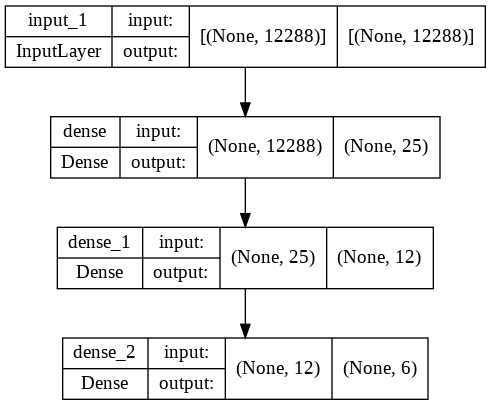

In [15]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True)

## Saving model

The SavedModel format (default)

In [21]:
model.save('/content/drive/MyDrive/HandSigns/SavedModel_format')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/HandSigns/SavedModel_format/assets


In [22]:
!ls /content/drive/MyDrive/HandSigns/SavedModel_format

assets	keras_metadata.pb  saved_model.pb  variables


The **HDF5** format

In [23]:
model.save('/content/drive/MyDrive/HandSigns/saved_model.h5')

In [24]:
!ls /content/drive/MyDrive/HandSigns/

SavedModel_format  saved_model.h5  test_signs.h5  train_signs.h5


## Loading model

In [25]:
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/HandSigns/SavedModel_format")
loaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 25)                307225    
                                                                 
 dense_4 (Dense)             (None, 12)                312       
                                                                 
 dense_5 (Dense)             (None, 6)                 78        
                                                                 
Total params: 307,615
Trainable params: 307,615
Non-trainable params: 0
_________________________________________________________________


In [26]:
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/HandSigns/saved_model.h5")
loaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 25)                307225    
                                                                 
 dense_4 (Dense)             (None, 12)                312       
                                                                 
 dense_5 (Dense)             (None, 6)                 78        
                                                                 
Total params: 307,615
Trainable params: 307,615
Non-trainable params: 0
_________________________________________________________________
